## Part B

In [2]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm

import qiskit
from qiskit import assemble, transpile
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error

import qiskit.ignis.verification.quantum_volume as qv

<ipython-input-2-a222b4e10082>:10: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  import qiskit.ignis.verification.quantum_volume as qv


Generate QV sequences

In [38]:
qubit_lists = [[0, 1, 3], [0, 1, 3, 5], [0, 1, 3, 5, 7], [0, 1, 3, 5, 7, 10]]
ntrials = 100

qv_circs, qv_circs_nomeas = qv.qv_circuits(qubit_lists, ntrials)

qv_circs_nomeas[0] = qiskit.compiler.transpile(qv_circs_nomeas[0], basis_gates=['u1','u2','u3','cx'])

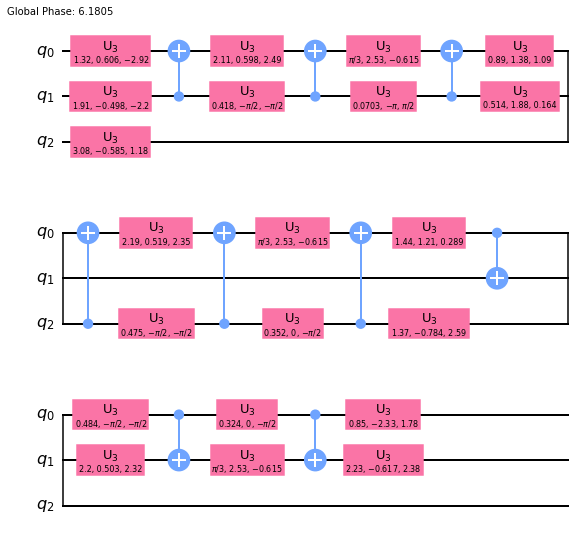

In [39]:
qv_circs_nomeas[0][0].draw(output='mpl', fold=11)

Simulate the ideal QV circuits

In [40]:
sv_sim = qiskit.Aer.get_backend('aer_simulator')
ideal_results = []
for trial in tqdm(range(ntrials)):
    clear_output(wait=True)
    for qc in qv_circs_nomeas[trial]:
        qc.save_statevector()
    result = qiskit.execute(qv_circs_nomeas[trial], backend=sv_sim).result()
    ideal_results.append(result)

qv_fitter = qv.QVFitter(qubit_lists=qubit_lists)
qv_fitter.add_statevectors(ideal_results)

100%|██████████| 100/100 [00:03<00:00, 33.19it/s]


Calculate the heavy outputs

In [41]:
# Take trial 0 as example
for qubit_list in qubit_lists:
    l = len(qubit_list)
    print (f'qv_depth_{l}_trial_0 heavy outputs:', qv_fitter._heavy_outputs[f'qv_depth_{l}_trial_0'])
    print (f'qv_depth_{l}_trial_0 heavy output probability:', qv_fitter._heavy_output_prob_ideal[f'qv_depth_{l}_trial_0'])

qv_depth_3_trial_0 heavy outputs: ['010', '011', '110', '111']
qv_depth_3_trial_0 heavy output probability: 0.6270729575186343
qv_depth_4_trial_0 heavy outputs: ['0000', '0001', '0011', '0100', '1000', '1001', '1100', '1111']
qv_depth_4_trial_0 heavy output probability: 0.8981375304397949
qv_depth_5_trial_0 heavy outputs: ['00011', '00110', '00111', '01000', '01010', '01100', '01101', '01110', '01111', '10001', '10010', '10011', '10100', '11010', '11100', '11101']
qv_depth_5_trial_0 heavy output probability: 0.8883554198289796
qv_depth_6_trial_0 heavy outputs: ['000110', '001100', '001110', '010000', '010001', '010010', '010100', '010101', '010110', '010111', '011010', '011011', '011100', '011101', '011110', '011111', '100000', '100001', '100011', '100100', '100111', '101001', '101010', '101101', '101110', '101111', '110001', '110011', '110110', '111000', '111001', '111110']
qv_depth_6_trial_0 heavy output probability: 0.8596929442388699


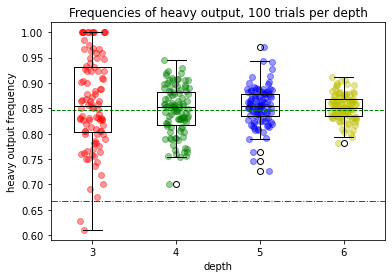

In [42]:
import numpy as np

width = 0.3

xs = [np.linspace(i+1 - width/2, i+1 + width/2, num=ntrials) for i in range(len(qubit_lists))]
depths = [len(qubit_list) for qubit_list in qubit_lists]
probs = [[qv_fitter._heavy_output_prob_ideal[f'qv_depth_{l}_trial_{trial}'] for trial in range(ntrials)] for l in depths]

plt.boxplot(probs, labels=depths, medianprops=dict(color='black'))
palette = ['r', 'g', 'b', 'y']
for x, val, c in zip(xs, probs, palette):
    plt.scatter(x, val, alpha=0.4, color=c)
plt.hlines((1+np.log(2))/2, xmin=0.5, xmax=len(qubit_lists)+0.5, linestyle='--', linewidth=1, color='green')
plt.hlines(2/3, xmin=0.5, xmax=len(qubit_lists)+0.5, linestyle='-.', linewidth=1, color='red')
plt.title(f"Frequencies of heavy output, {ntrials} trials per depth")
plt.xlabel("depth")
plt.ylabel("heavy output frequency")
plt.show()

## Part C

Define the noise model

In [43]:
noise_model = NoiseModel()
p1Q = 0.002
p2Q = 0.02
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(2*p1Q, 1), 'u3')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')

In [44]:
aer_sim = qiskit.Aer.get_backend('aer_simulator')
basis_gates = ['u1', 'u2', 'u3', 'cx']
shots = 1024
exp_results = []
for trial in tqdm(range(ntrials)):
    clear_output(wait=True)
    t_qcs = transpile(qv_circs[trial], basis_gates=basis_gates, optimization_level=3)
    qobj = assemble(t_qcs)
    result = aer_sim.run(qobj, noise_model=noise_model, max_parallel_experiments=0).result()
    exp_results.append(result)

100%|██████████| 100/100 [01:31<00:00,  1.09it/s]


Calculate the average gate fidelity

In [45]:
qv_fitter = qv.QVFitter(qubit_lists=qubit_lists)
qv_fitter.add_statevectors(ideal_results)
qv_fitter.add_data(exp_results)
for qubit_list in qubit_lists:
    l = len(qubit_list)
    print(f'qv_depth_{l}_trial_0:', qv_fitter._heavy_output_counts[f'qv_depth_{l}_trial_0'])

qv_depth_3_trial_0: 656
qv_depth_4_trial_0: 783
qv_depth_5_trial_0: 749
qv_depth_6_trial_0: 661


Calculate the achievable depth

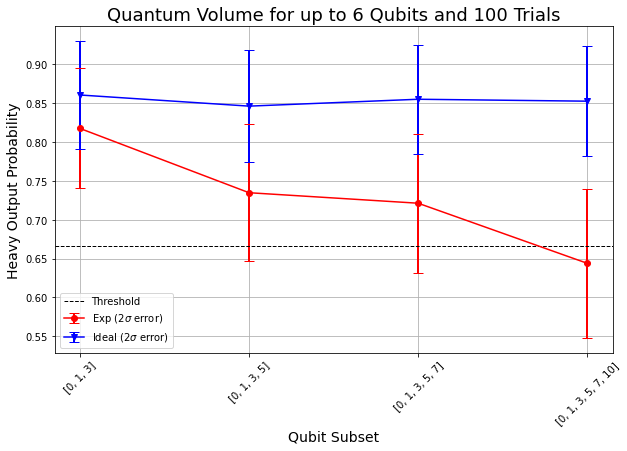

In [46]:
plt.figure(figsize=(10, 6))
ax = plt.gca()

qv_fitter.plot_qv_data(ax=ax, show_plt=False)

ax.set_title(f"Quantum Volume for up to {len(qubit_lists[-1])} Qubits and {ntrials} Trials", fontsize=18)

plt.show()

Calculate the Quantum Volume

In [47]:
qv_success_list = qv_fitter.qv_success()
qv_list = qv_fitter.ydata
QV = 1
for qidx, qubit_list in enumerate(qubit_lists):
    if qv_list[0][qidx] > 2/3:
        if qv_success_list[qidx][0]:
            QV = qv_fitter.quantum_volume()[qidx]
            print(f"Width/depth {len(qubit_list)} greater than 2/3 ({qv_list[0][qidx]}) with confidence {qv_success_list[qidx][1]} (successful). Quantum volume {QV}")
        else:
            print(f"Width/depth {len(qubit_list)} greater than 2/3 ({qv_list[0][qidx]}) with confidence {qv_success_list[qidx][1]} (unsuccessful).")
    else:
        print(f"Width/depth {len(qubit_list)} less than 2/3 (unsuccessful).")

print(f"Quantum Volume is: {QV}")

Width/depth 3 greater than 2/3 (0.817529296875) with confidence 0.9999530838403174 (successful). Quantum volume 8
Width/depth 4 greater than 2/3 (0.734775390625) with confidence 0.9385641833012872 (unsuccessful).
Width/depth 5 greater than 2/3 (0.721259765625) with confidence 0.8883052904370681 (unsuccessful).
Width/depth 6 less than 2/3 (unsuccessful).
Quantum Volume is: 8


Different noise models

In [48]:
def noisy_qv_exp(noise_model):
    aer_sim = qiskit.Aer.get_backend('aer_simulator')
    basis_gates = ['u1', 'u2', 'u3', 'cx']
    shots = 1024
    exp_results = []
    for trial in tqdm(range(ntrials)):
        clear_output(wait=True)
        t_qcs = transpile(qv_circs[trial], basis_gates=basis_gates, optimization_level=3)
        qobj = assemble(t_qcs)
        result = aer_sim.run(qobj, noise_model=noise_model, max_parallel_experiments=0).result()
        exp_results.append(result)
    
    qv_fitter = qv.QVFitter(qubit_lists=qubit_lists)
    qv_fitter.add_statevectors(ideal_results)
    qv_fitter.add_data(exp_results)
    # for qubit_list in qubit_lists:
    #     l = len(qubit_list)
    #     print(f'qv_depth_{l}_trial_0:', qv_fitter._heavy_output_counts[f'qv_depth_{l}_trial_0'])
    
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    qv_fitter.plot_qv_data(ax=ax, show_plt=False)
    ax.set_title(f"Quantum Volume for up to {len(qubit_lists[-1])} Qubits and {ntrials} Trials", fontsize=18)
    plt.show()

    qv_success_list = qv_fitter.qv_success()
    qv_list = qv_fitter.ydata
    QV = 1
    for qidx in range(len(qubit_lists)):
        if (qv_list[0][qidx] > 2/3) and qv_success_list[qidx][0]:
            QV = qv_fitter.quantum_volume()[qidx]
    
    return QV

100%|██████████| 100/100 [01:30<00:00,  1.11it/s]


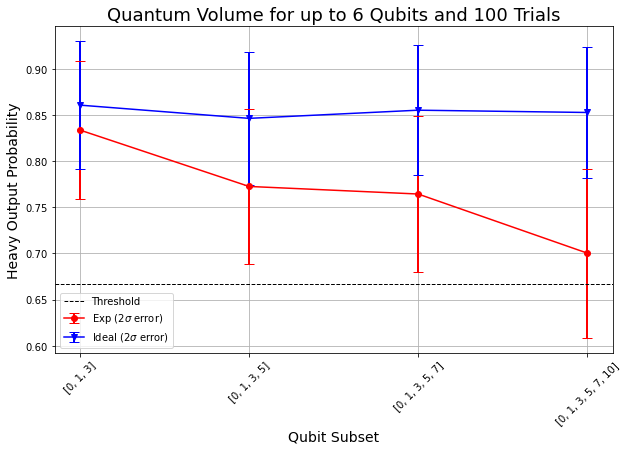

32


In [49]:
noise_model = NoiseModel()
p1Q = 0.002
p2Q = 0.01
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(2*p1Q, 1), 'u3')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')

qv1 = noisy_qv_exp(noise_model)
print(qv1)

100%|██████████| 100/100 [01:32<00:00,  1.09it/s]


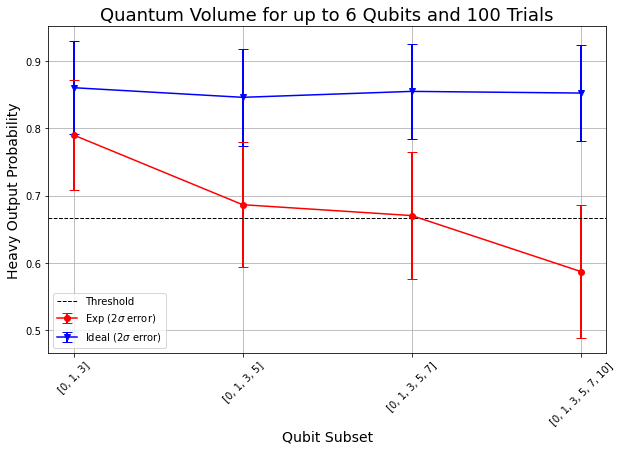

8


In [50]:
noise_model = NoiseModel()
p1Q = 0.01
p2Q = 0.01
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(2*p1Q, 1), 'u3')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')

qv2 = noisy_qv_exp(noise_model)
print(qv2)

100%|██████████| 100/100 [01:30<00:00,  1.11it/s]


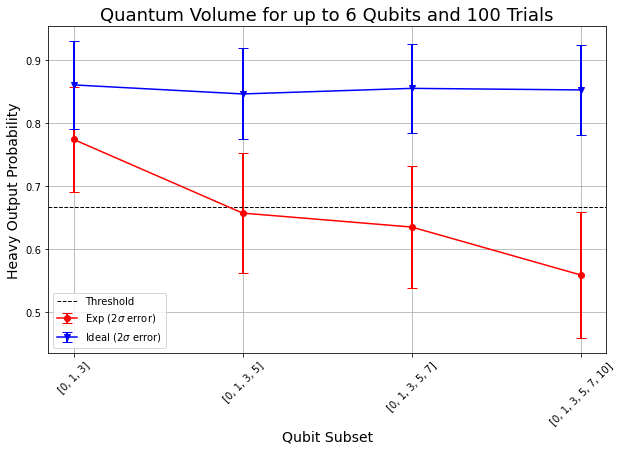

8


In [51]:
noise_model = NoiseModel()
p1Q = 0.002
p2Q = 0.05
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(2*p1Q, 1), 'u3')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')

qv3 = noisy_qv_exp(noise_model)
print(qv3)

100%|██████████| 100/100 [01:30<00:00,  1.10it/s]


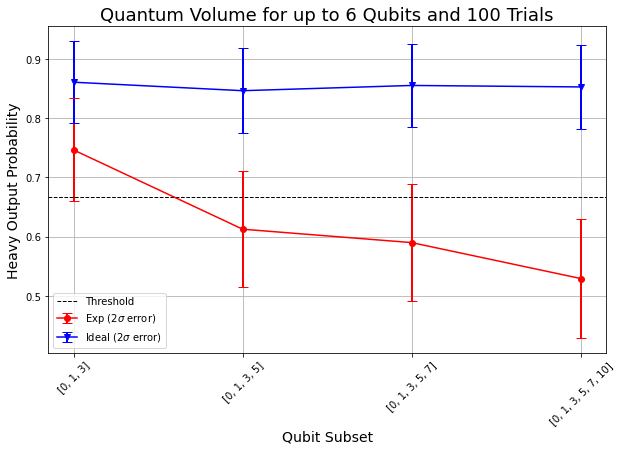

1


In [53]:
noise_model = NoiseModel()
p1Q = 0.01
p2Q = 0.05
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(2*p1Q, 1), 'u3')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')

qv4 = noisy_qv_exp(noise_model)
print(qv4)

Real quantum hardware (error mitigated)

In [62]:
from qiskit import IBMQ

provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_manila')

ibmqfactory.load_account:WARNING:2021-12-24 13:50:54,654: Credentials are already in use. The existing account in the session will be replaced.


In [58]:
qubit_lists = [[3, 4], [2, 3, 4], [1, 2, 3, 4], [0, 1, 2, 3, 4]]
ntrials = 100

qv_circs, qv_circs_nomeas = qv.qv_circuits(qubit_lists, ntrials)

In [59]:
sv_sim = qiskit.Aer.get_backend('aer_simulator')
ideal_results = []
for trial in tqdm(range(ntrials)):
    clear_output(wait=True)
    for qc in qv_circs_nomeas[trial]:
        qc.save_statevector()
    result = qiskit.execute(qv_circs_nomeas[trial], backend=sv_sim).result()
    ideal_results.append(result)

qv_fitter = qv.QVFitter(qubit_lists=qubit_lists)
qv_fitter.add_statevectors(ideal_results)

100%|██████████| 100/100 [00:01<00:00, 52.72it/s]


In [64]:
program = provider.runtime.program('circuit-runner')
options = {'backend_name': backend.name()}

jobs = []
for circ in qv_circs:
    runtime_inputs = {
        'circuits': circ,
        'measurement_error_mitigation': True,
        'optimization_level': 3
    }
    jobs.append(provider.runtime.run(program_id='circuit-runner', options=options, inputs=runtime_inputs))

In [65]:
for job in jobs:
    print(job.job_id())

c72m2ptv72p78sr3agmg
c72m2q16o8pbbftpq0s0
c72m2qdv72p78sr3agqg
c72m2qh6o8pbbftpq10g
c72m2qil3vjaum2muvr0
c72m2qql3vjaum2muvu0
c72m2r2l3vjaum2mv000
c72m2r96o8pbbftpq15g
c72m2rdv72p78sr3agvg
c72m2rh6o8pbbftpq18g
c72m2rtv72p78sr3ah30
c72m2s5v72p78sr3ah4g
c72m2s96o8pbbftpq1dg
c72m2sal3vjaum2mv08g
c72m2slv72p78sr3ah8g
c72m2sp6o8pbbftpq1h0
c72m2t2l3vjaum2mv0b0
c72m2t2l3vjaum2mv0dg
c72m2t96o8pbbftpq1m0
c72m2tlv72p78sr3ahig
c72m2ttv72p78sr3ahk0
c72m2u5v72p78sr3ahm0
c72m2u16o8pbbftpq1r0
c72m2ual3vjaum2mv0mg
c72m2uh6o8pbbftpq200
c72m2ulv72p78sr3ahq0
c72m2up6o8pbbftpq22g
c72m2v5v72p78sr3ahsg
c72m2val3vjaum2mv0rg
c72m2vil3vjaum2mv0tg
c72m2vlv72p78sr3ai20
c72m2vql3vjaum2mv110
c72m3016o8pbbftpq280
c72m30al3vjaum2mv13g
c72m3096o8pbbftpq2ag
c72m30h6o8pbbftpq2d0
c72m30tv72p78sr3ai80
c72m30p6o8pbbftpq2fg
c72m315v72p78sr3aiag
c72m3196o8pbbftpq2ig
c72m31dv72p78sr3aic0
c72m31il3vjaum2mv1d0
c72m31lv72p78sr3aid0
c72m31ql3vjaum2mv1eg
c72m322l3vjaum2mv1fg
c72m322l3vjaum2mv1ig
c72m32dv72p78sr3aij0
c72m32h6o8pbb

In [10]:
from qiskit.providers.ibmq import RunnerResult

real_results = []
for job in tqdm(jobs):
    result = job.result(decoder=RunnerResult)
    real_results.append(result)

100%|██████████| 100/100 [05:29<00:00,  3.29s/it]


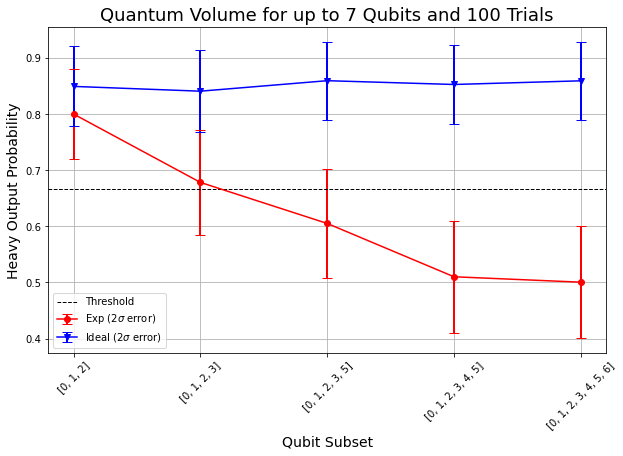

8


In [12]:
qv_fitter.add_data(real_results)
# for qubit_list in qubit_lists:
#     l = len(qubit_list)
#     print(f'qv_depth_{l}_trial_0:', qv_fitter._heavy_output_counts[f'qv_depth_{l}_trial_0'])

plt.figure(figsize=(10, 6))
ax = plt.gca()
qv_fitter.plot_qv_data(ax=ax, show_plt=False)
ax.set_title(f"Quantum Volume for up to {len(qubit_lists[-1])} Qubits and {ntrials} Trials", fontsize=18)
plt.show()

qv_success_list = qv_fitter.qv_success()
qv_list = qv_fitter.ydata
QV = 1
for qidx in range(len(qubit_lists)):
    if (qv_list[0][qidx] > 2/3) and qv_success_list[qidx][0]:
        QV = qv_fitter.quantum_volume()[qidx]
print(QV)

In [12]:
import qiskit.tools.jupyter
%qiskit_version_table